# Computing the optimal statistic with enterprise

In this notebook you will learn how to compute the optimal statistic. The optimal statistic is a frequentist detection statistic for the stochastic background. It assesses the significance of the cross-correlations, and compares them to the Hellings-Downs curve.

For more information, see [Anholm et al. 2009](https://arxiv.org/abs/0809.0701), [Demorest et al. 2013](https://arxiv.org/abs/1201.6641), [Chamberlin et al. 2015](https://arxiv.org/abs/1410.8256), [Vigeland et al. 2018](https://arxiv.org/abs/1805.12188).

This notebook shows you how to compute the optimal statistic for the 12.5yr data set.

To run this notebook without using your own computer, we have prepared a [Google Colab notebook](https://colab.research.google.com/drive/1VNLbutN7cKJM2jl6LId0IgkGJDszDloC#scrollTo=bwMNlFWuQhnB).

## Imports, data loading, and setup

In [1]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
import numpy as np
import pickle
import json
import glob
import os
import math
import scipy


import matplotlib.pyplot as plt
%matplotlib inline


from enterprise.signals import signal_base
from enterprise.signals import gp_signals
from enterprise.pulsar import Pulsar
from enterprise.signals import parameter
from enterprise.signals import gp_priors
from enterprise.signals import utils

from enterprise_extensions import model_utils, blocks
from enterprise_extensions import model_orfs
from enterprise_extensions.frequentist import optimal_statistic as opt_stat
from enterprise.signals import selections
import enterprise_extensions.chromatic.chromatic
from enterprise_extensions.chromatic import dm_exponential_dip


import h5py
import la_forge.core as co

In [2]:
import pickle
with open('/Users/kalistaw/Desktop/OS_2023_data/NG_3P_comparison/ppta/psrs_ppta_dr3.pkl','rb') as fin:
    psrs=pickle.load(fin)

In [3]:
for p in psrs: 
    print(p.name)

J0030+0451
J0125-2327
J0437-4715
J0613-0200
J0614-3329
J0711-6830
J1017-7156
J1022+1001
J1024-0719
J1045-4509
J1125-6014
J1446-4701
J1545-4550
J1600-3053
J1603-7202
J1643-1224
J1713+0747
J1730-2304
J1744-1134
J1824-2452A
J1832-0836
J1857+0943
J1909-3744
J1933-6211
J1939+2134
J2124-3358
J2129-5721
J2145-0750
J2241-5236


In [4]:
len(psrs)

29

In [5]:
for p in psrs:
    p.name=p.name+'_ppta'

In [6]:
for p in psrs: 
    print(p.name)

J0030+0451_ppta
J0125-2327_ppta
J0437-4715_ppta
J0613-0200_ppta
J0614-3329_ppta
J0711-6830_ppta
J1017-7156_ppta
J1022+1001_ppta
J1024-0719_ppta
J1045-4509_ppta
J1125-6014_ppta
J1446-4701_ppta
J1545-4550_ppta
J1600-3053_ppta
J1603-7202_ppta
J1643-1224_ppta
J1713+0747_ppta
J1730-2304_ppta
J1744-1134_ppta
J1824-2452A_ppta
J1832-0836_ppta
J1857+0943_ppta
J1909-3744_ppta
J1933-6211_ppta
J1939+2134_ppta
J2124-3358_ppta
J2129-5721_ppta
J2145-0750_ppta
J2241-5236_ppta


In [7]:
psrs2=[]
for p in psrs: 
    if p.name == 'J2241-5236_ppta':
        pass
    elif p.name=='J1824-2452A_ppta':
        pass
    else:
        psrs2.append(p)

In [8]:
import glob
noise_paths=[]
paths=glob.glob("/Users/kalistaw/Desktop/OS_2023_data/NG_3P_comparison/ppta/wn_dict_ppta.json")
for i in paths:
    noise_paths.append(i)

In [9]:
# Load up the noise dictionary to get values for the white noise parameters
# Change the noisefile to point to where you have saved the noisefile
noisedict= {}

for i in noise_paths:
    with open(i, 'r') as f:
        noisefile = json.load(f)
        noisedict.update(noisefile)

In [10]:
noisedict

{'J0030+0451_UWL_sbA_efac': 1.0395205071179219,
 'J0030+0451_UWL_sbA_log10_t2equad': -5.961436609187894,
 'J0030+0451_UWL_sbB_efac': 1.08572856933657,
 'J0030+0451_UWL_sbB_log10_t2equad': -7.655549541251448,
 'J0030+0451_UWL_sbC_efac': 1.0981140220620083,
 'J0030+0451_UWL_sbC_log10_t2equad': -7.412909501034909,
 'J0030+0451_UWL_sbD_efac': 1.120312377175945,
 'J0030+0451_UWL_sbD_log10_t2equad': -7.189635297173146,
 'J0030+0451_UWL_sbE_efac': 0.9616005092258848,
 'J0030+0451_UWL_sbE_log10_t2equad': -6.059659477735372,
 'J0030+0451_UWL_sbF_efac': 0.960249804491331,
 'J0030+0451_UWL_sbF_log10_t2equad': -7.465505711251239,
 'J0030+0451_UWL_sbG_efac': 0.8012069830678203,
 'J0030+0451_UWL_sbG_log10_t2equad': -5.4246762790085725,
 'J0030+0451_UWL_sbH_efac': 0.8210346267788027,
 'J0030+0451_UWL_sbH_log10_t2equad': -8.285995953881807,
 'J0030+0451_dm_gp_gamma': 4.679213653756971,
 'J0030+0451_dm_gp_log10_A': -16.383774285763725,
 'J0030+0451_red_noise_gamma': 4.742835041548172,
 'J0030+0451_red_

In [11]:
noisedictcp2=noisedict.copy()
for ky,val in noisedict.items():
    split=ky.split('_')
    split.insert(1,'ppta')
    kynew='_'.join(split)
    noisedictcp2[kynew] = noisedict[ky]
for ky,val in noisedict.items():
    if ky in noisedict:
        noisedictcp2.pop(ky)

In [12]:
noisedictcp2

{'J0030+0451_ppta_UWL_sbA_efac': 1.0395205071179219,
 'J0030+0451_ppta_UWL_sbA_log10_t2equad': -5.961436609187894,
 'J0030+0451_ppta_UWL_sbB_efac': 1.08572856933657,
 'J0030+0451_ppta_UWL_sbB_log10_t2equad': -7.655549541251448,
 'J0030+0451_ppta_UWL_sbC_efac': 1.0981140220620083,
 'J0030+0451_ppta_UWL_sbC_log10_t2equad': -7.412909501034909,
 'J0030+0451_ppta_UWL_sbD_efac': 1.120312377175945,
 'J0030+0451_ppta_UWL_sbD_log10_t2equad': -7.189635297173146,
 'J0030+0451_ppta_UWL_sbE_efac': 0.9616005092258848,
 'J0030+0451_ppta_UWL_sbE_log10_t2equad': -6.059659477735372,
 'J0030+0451_ppta_UWL_sbF_efac': 0.960249804491331,
 'J0030+0451_ppta_UWL_sbF_log10_t2equad': -7.465505711251239,
 'J0030+0451_ppta_UWL_sbG_efac': 0.8012069830678203,
 'J0030+0451_ppta_UWL_sbG_log10_t2equad': -5.4246762790085725,
 'J0030+0451_ppta_UWL_sbH_efac': 0.8210346267788027,
 'J0030+0451_ppta_UWL_sbH_log10_t2equad': -8.285995953881807,
 'J0030+0451_ppta_dm_gp_gamma': 4.679213653756971,
 'J0030+0451_ppta_dm_gp_log10_A'

In [12]:
"""
#Run once to save renamed files then can load at convience 
noise=noisedictcp2
# create a binary pickle file 
f = open("/Users/kalistaw/Desktop/OS_2023_data/ppta_noise_params.pkl","wb")
# write the python object (dict) to pickle file
pickle.dump(noise,f)
# close file
f.close()

"""

'\n#Run once to save renamed files then can load at convience \nnoise=noisedictcp2\n# create a binary pickle file \nf = open("/Users/kalistaw/Desktop/OS_2023_data/ppta_noise_params.pkl","wb")\n# write the python object (dict) to pickle file\npickle.dump(noise,f)\n# close file\nf.close()\n\n'

In [13]:
%%time
# (Note: It may take a few minutes to run this cell and may require at least ~4GB RAM)
# Initialize the optimal statistic object
# You can give it a list of pulsars and the noise dictionary, and it will create the pta object for you
# Alternatively, you can make the pta object yourself and give it to the OptimalStatistic object as an argument

# find the maximum time span to set GW frequency sampling
Tspan = model_utils.get_tspan(psrs2)

#model_utils.get_tspan(psrs2)

#326044597.6654711 #EPTA TSPAN

#505861299.1401644 #NANOGRAV TSPAN

#model_utils.get_tspan(psrs2)

tm = gp_signals.TimingModel(use_svd=True)

wn = blocks.white_noise_block(vary=False, inc_ecorr=False, select='backend')


rn = blocks.red_noise_block(components=30, Tspan=Tspan)

dmgp = blocks.dm_noise_block(components=100, Tspan=Tspan)

crn = blocks.common_red_noise_block(
    components=10,
    orf=None,
    Tspan=Tspan,
    gamma_val=13/3,
    name="gw"
    
)

s_crn = tm + wn + rn + dmgp + crn

models = []
for p in psrs2:
    s = s_crn
    if p.name == "J1713+0747_ppta":
        s += dm_exponential_dip(54700, 54800, 
                                idx=parameter.Uniform(1, 5),
                                name="dmexp_1")
        s += dm_exponential_dip(57500, 57520, 
                                idx=parameter.Uniform(1, 5),
                                name="dmexp_2")

    models.append(s(p))
pta = signal_base.PTA(models)
pta.set_default_params(noisedictcp2)


CPU times: user 3.89 s, sys: 170 ms, total: 4.06 s
Wall time: 4.09 s


In [15]:
import cloudpickle
with open('/Users/kalistaw/Desktop/OS_2023_data/ppta_models_tspan_ppta_fx_gamma_one_curn_spline.pkl','wb') as fout:
    cloudpickle.dump(pta,fout)

In [15]:
#frequncies_ppta=np.array([1/Tspan,2/Tspan,3/Tspan,4/Tspan,5/Tspan,6/Tspan,7/Tspan,8/Tspan,9/Tspan,10/Tspan])

In [16]:
#np.save("/Users/kalistaw/Desktop/OS_2023_data/frequncies_ppta.npy",frequncies_ppta)

In [13]:
print(pta.summary())

enterprise v3.3.2,  Python v3.9.16

Signal Name                              Signal Class                   no. Parameters      
J0030+0451_ppta_linear_timing_model_svd  TimingModel                    0                   

params:
__________________________________________________________________________________________
J0030+0451_ppta_measurement_noise        MeasurementNoise               0                   

params:
J0030+0451_ppta_UWL_sbA_efac:Constant=1.0395205071179219                                  
J0030+0451_ppta_UWL_sbA_log10_t2equad:Constant=-5.961436609187894                         
J0030+0451_ppta_UWL_sbB_efac:Constant=1.08572856933657                                    
J0030+0451_ppta_UWL_sbB_log10_t2equad:Constant=-7.655549541251448                         
J0030+0451_ppta_UWL_sbC_efac:Constant=1.0981140220620083                                  
J0030+0451_ppta_UWL_sbC_log10_t2equad:Constant=-7.412909501034909                         
J0030+0451_ppta_UWL_sbD_efac:C

In [18]:

#Code to generate and save max likelihood parameters only need to run once
#To get the files generated
#c0 = co.Core(chaindir='/Users/kalistaw/Desktop/OS_2023_data/NG_3P_comparison/ppta/model_2a_10f/')
#max_like=c0.get_map_dict()
# create a binary pickle file 
#f = open("/Users/kalistaw/Desktop/OS_2023_data/ppta_ml_params.json","w")
# write the python object (dict) to pickle file
#json.dump(max_like,f)
# close file
#f.close()


In [19]:
#c0.save("/Users/kalistaw/Desktop/OS_2023_data/ppta_dmgp_core_fx_gamma.h5")

In [14]:
c0=co.Core(corepath="/Users/kalistaw/Desktop/OS_2023_data/ppta_dmgp_core.h5")

Loading data from HDF5 file....


In [15]:
max_like=c0.get_map_dict()

In [16]:
ml_params=max_like

In [17]:
ml_params

{'J0030+0451_dm_gp_gamma': 0.501450944106193,
 'J0030+0451_dm_gp_log10_A': -13.209223364028881,
 'J0030+0451_red_noise_gamma': 1.2599862565651045,
 'J0030+0451_red_noise_log10_A': -12.969958463873438,
 'J0125-2327_dm_gp_gamma': 1.365638991295455,
 'J0125-2327_dm_gp_log10_A': -13.309623455578395,
 'J0125-2327_red_noise_gamma': 2.596990394215151,
 'J0125-2327_red_noise_log10_A': -19.156321756369596,
 'J0437-4715_dm_gp_gamma': 2.1496030055971658,
 'J0437-4715_dm_gp_log10_A': -13.43276102521021,
 'J0437-4715_red_noise_gamma': 1.2056468964190645,
 'J0437-4715_red_noise_log10_A': -13.59217990065759,
 'J0613-0200_dm_gp_gamma': 1.9398733480115227,
 'J0613-0200_dm_gp_log10_A': -13.252145296543846,
 'J0613-0200_red_noise_gamma': 1.183083260736114,
 'J0613-0200_red_noise_log10_A': -18.245411536503617,
 'J0614-3329_dm_gp_gamma': 2.513250678003764,
 'J0614-3329_dm_gp_log10_A': -13.214867434703804,
 'J0614-3329_red_noise_gamma': 1.8385500349870554,
 'J0614-3329_red_noise_log10_A': -14.35680267206233

In [18]:
ml_paramscp=ml_params.copy()
for ky,val in ml_params.items():
    if "earth" not in ky:
        split=ky.split('_')
        split.insert(1,'ppta')
        kynew='_'.join(split)
        ml_paramscp[kynew] = ml_params[ky]
    else:
        ml_paramscp[ky] = ml_params[ky]
for ky,val in ml_params.items():
    if ky in ml_params and "earth" not in ky:
        ml_paramscp.pop(ky)
ml_paramscp['gw_log10_A']=ml_paramscp['gw_ppta_crn_log10_A']
ml_paramscp['gw_gamma']=ml_paramscp['gw_ppta_crn_gamma']

In [19]:
ml_paramscp

{'J0030+0451_ppta_dm_gp_gamma': 0.501450944106193,
 'J0030+0451_ppta_dm_gp_log10_A': -13.209223364028881,
 'J0030+0451_ppta_red_noise_gamma': 1.2599862565651045,
 'J0030+0451_ppta_red_noise_log10_A': -12.969958463873438,
 'J0125-2327_ppta_dm_gp_gamma': 1.365638991295455,
 'J0125-2327_ppta_dm_gp_log10_A': -13.309623455578395,
 'J0125-2327_ppta_red_noise_gamma': 2.596990394215151,
 'J0125-2327_ppta_red_noise_log10_A': -19.156321756369596,
 'J0437-4715_ppta_dm_gp_gamma': 2.1496030055971658,
 'J0437-4715_ppta_dm_gp_log10_A': -13.43276102521021,
 'J0437-4715_ppta_red_noise_gamma': 1.2056468964190645,
 'J0437-4715_ppta_red_noise_log10_A': -13.59217990065759,
 'J0613-0200_ppta_dm_gp_gamma': 1.9398733480115227,
 'J0613-0200_ppta_dm_gp_log10_A': -13.252145296543846,
 'J0613-0200_ppta_red_noise_gamma': 1.183083260736114,
 'J0613-0200_ppta_red_noise_log10_A': -18.245411536503617,
 'J0614-3329_ppta_dm_gp_gamma': 2.513250678003764,
 'J0614-3329_ppta_dm_gp_log10_A': -13.214867434703804,
 'J0614-3329

In [20]:
dm_gp_max_like=ml_paramscp.copy()
for key,val in ml_paramscp.items():
    if "dm" not in key:
        dm_gp_max_like.pop(key)
    else:
        pass

In [21]:
dm_gp_max_like

{'J0030+0451_ppta_dm_gp_gamma': 0.501450944106193,
 'J0030+0451_ppta_dm_gp_log10_A': -13.209223364028881,
 'J0125-2327_ppta_dm_gp_gamma': 1.365638991295455,
 'J0125-2327_ppta_dm_gp_log10_A': -13.309623455578395,
 'J0437-4715_ppta_dm_gp_gamma': 2.1496030055971658,
 'J0437-4715_ppta_dm_gp_log10_A': -13.43276102521021,
 'J0613-0200_ppta_dm_gp_gamma': 1.9398733480115227,
 'J0613-0200_ppta_dm_gp_log10_A': -13.252145296543846,
 'J0614-3329_ppta_dm_gp_gamma': 2.513250678003764,
 'J0614-3329_ppta_dm_gp_log10_A': -13.214867434703804,
 'J0711-6830_ppta_dm_gp_gamma': 2.1949118438254414,
 'J0711-6830_ppta_dm_gp_log10_A': -13.41963643222822,
 'J1017-7156_ppta_dm_gp_gamma': 1.8370878273213038,
 'J1017-7156_ppta_dm_gp_log10_A': -12.88584805739009,
 'J1022+1001_ppta_dm_gp_gamma': 0.4503272730814078,
 'J1022+1001_ppta_dm_gp_log10_A': -13.05142321999575,
 'J1024-0719_ppta_dm_gp_gamma': 3.160944258931104,
 'J1024-0719_ppta_dm_gp_log10_A': -13.734906570860453,
 'J1045-4509_ppta_dm_gp_gamma': 2.73384416732

In [22]:
f = open("/Users/kalistaw/Desktop/OS_2023_data/ppta_dmgp_max.pkl","wb")
# write the python object (dict) to pickle file
pickle.dump(dm_gp_max_like,f)
# close file
f.close()

In [23]:
for ky in ml_paramscp.keys():
    if ky not in pta.param_names:
        print(ky)

gw_ppta_crn_gamma
gw_ppta_crn_log10_A
lnpost_ppta
lnlike_ppta
chain_ppta_accept
pt_ppta_chain_accept
gw_gamma


In [21]:
for ky in pta.param_names:
    if ky not in ml_paramscp.keys() :
        print(ky)

In [22]:
'''
#Run once to save renamed files then can load at convience 
ml=ml_paramscp
# create a binary pickle file 
f = open("/Users/physics/nanogw/data/ng_ml_params_renamed.pkl","wb")
# write the python object (dict) to pickle file
pickle.dump(ml,f)
# close file
f.close()
'''

'\n#Run once to save renamed files then can load at convience \nml=ml_paramscp\n# create a binary pickle file \nf = open("/Users/physics/nanogw/data/ng_ml_params_renamed.pkl","wb")\n# write the python object (dict) to pickle file\npickle.dump(ml,f)\n# close file\nf.close()\n'

## Optimal statistics with maximum likelihood noise parameters

In [22]:
ostat = opt_stat.OptimalStatistic(psrs2, pta=pta, orf='hd',gamma_common=None)
ostat_dip = opt_stat.OptimalStatistic(psrs2, pta=pta, orf='dipole',gamma_common=None)
ostat_mono = opt_stat.OptimalStatistic(psrs2, pta=pta, orf='monopole',gamma_common=None)

In [23]:
ostat

In [24]:
ml_paramscp

{'J0030+0451_ppta_dm_gp_gamma': 0.501450944106193,
 'J0030+0451_ppta_dm_gp_log10_A': -13.209223364028881,
 'J0030+0451_ppta_red_noise_gamma': 1.2599862565651045,
 'J0030+0451_ppta_red_noise_log10_A': -12.969958463873438,
 'J0125-2327_ppta_dm_gp_gamma': 1.365638991295455,
 'J0125-2327_ppta_dm_gp_log10_A': -13.309623455578395,
 'J0125-2327_ppta_red_noise_gamma': 2.596990394215151,
 'J0125-2327_ppta_red_noise_log10_A': -19.156321756369596,
 'J0437-4715_ppta_dm_gp_gamma': 2.1496030055971658,
 'J0437-4715_ppta_dm_gp_log10_A': -13.43276102521021,
 'J0437-4715_ppta_red_noise_gamma': 1.2056468964190645,
 'J0437-4715_ppta_red_noise_log10_A': -13.59217990065759,
 'J0613-0200_ppta_dm_gp_gamma': 1.9398733480115227,
 'J0613-0200_ppta_dm_gp_log10_A': -13.252145296543846,
 'J0613-0200_ppta_red_noise_gamma': 1.183083260736114,
 'J0613-0200_ppta_red_noise_log10_A': -18.245411536503617,
 'J0614-3329_ppta_dm_gp_gamma': 2.513250678003764,
 'J0614-3329_ppta_dm_gp_log10_A': -13.214867434703804,
 'J0614-3329

In [25]:
# Compute the optimal statistic
# The optimal statistic returns five quantities:
#  - xi: an array of the angular separations between the pulsar pairs (in radians)
#  - rho: an array of the cross-correlations between the pulsar pairs
#  - sig: an array of the uncertainty in the cross-correlations
#  - OS: the value of the optimal statistic
#  - OS_sig: the uncertainty in the optimal statistic

xi, rho, sig, OS, OS_sig = ostat.compute_os(params=ml_paramscp) #HD


_, _, _, OS_dip, OS_sig_dip = ostat_dip.compute_os(params=ml_paramscp) #Dipole


_, _, _, OS_mono, OS_sig_mono = ostat_mono.compute_os(params=ml_paramscp) #Monopole 

In [26]:
print(OS, OS_sig, OS/OS_sig)
print(OS_dip, OS_sig_dip, OS_dip/OS_sig_dip)
print(OS_mono, OS_sig_mono, OS_mono/OS_sig_mono)

-4.679351874263331e-34 2.1013512965950385e-33 -0.22268298888651322
-4.296713687760118e-34 5.389118099633013e-34 -0.7972944011103997
-2.157402403792132e-34 3.2957672086265647e-34 -0.6545979334175062


In [27]:
class OS:
    def __init__(self, psrs, pta, params):
        self.psrs, self.params = psrs, params
        self.pairs  = [(i,j) for i in range(len(pta)) for j in range(i+1, len(pta))]
        self.angles = np.array([np.arccos(np.dot(self.psrs[i].pos, self.psrs[j].pos)) for (i,j) in self.pairs])
        
        ys = [sm._residuals for sm in pta]
        Cs = [Cmat(sm, params) for sm in pta]

        Fgws  = [sm['gw'].get_basis(params) for sm in pta]
        self.Gamma = np.array(pta[0]['gw'].get_phi({**params, 'gw_log10_A': 0})).copy()
        assert self.Gamma.ndim == 1

        FCys = [C.solve(y, Fgw) for C, y, Fgw in zip(Cs, ys, Fgws)]
        self.FCFs = [C.solve(Fgw, Fgw) for C, Fgw in zip(Cs, Fgws)]
        
        # a . np.diag(g) . b = a . (g * b) = (a * g) . b
        ts = [np.dot(FCys[i], self.Gamma * FCys[j]) for (i,j) in self.pairs]
        # A . np.diag(g) . B = (A * g) . B
        bs = [np.trace(np.dot(self.FCFs[i] * self.Gamma, self.FCFs[j] * self.Gamma)) for (i,j) in self.pairs]
        
        self.rhos   = np.array(ts) / np.array(bs)
        self.sigmas = 1.0 / np.sqrt(bs)
    
    def _set_orf(self, orf):
        if not hasattr(self, '_orf') or self._orf is not orf:
            self.orfs = np.array([orf(self.psrs[i].pos, self.psrs[j].pos) for (i,j) in self.pairs])        
            self._orf = orf
    
    def os(self, orf=utils.hd_orf, sel=(lambda p: slice(None))):
        self._set_orf(orf)
        
        mask = sel(self.pairs)
        return (np.sum(self.rhos[mask] * self.orfs[mask] / self.sigmas[mask]**2) /
                np.sum(self.orfs[mask]**2 / self.sigmas[mask]**2))
    
    def os_sigma(self, orf=utils.hd_orf, sel=(lambda p: slice(None))):
        self._set_orf(orf)

        mask = sel(self.pairs)
        return 1.0 / np.sqrt(np.sum(self.orfs[mask]**2 / self.sigmas[mask]**2))
    
    def gw_mean(self):
        return np.array([10**(2.0 * self.params['gw_log10_A'])] * len(self.pairs))
    
    def _tracedot(self, orf, *args):        
        ret = np.identity(len(self.Gamma))
    
        for i, (j,k) in zip(args[::2], args[1::2]):
            ret = np.dot(ret, self.FCFs[i] * self.Gamma * orf(self.psrs[j].pos, self.psrs[k].pos))
        
        return np.trace(ret)
    
    def gw_corr(self, orf=utils.hd_orf):
        Agw = 10**self.params['gw_log10_A']
        self.orfs = np.array([orf(self.psrs[i].pos, self.psrs[j].pos) for (i,j) in self.pairs])
        
        sigma = np.zeros((len(self.pairs), len(self.pairs)), 'd')
        
        for ij in range(len(self.pairs)):
            i, j = self.pairs[ij]
            
            for kl in range(ij, len(self.pairs)):
                k, l = self.pairs[kl]
                
                if ij == kl:
                    sigma[ij, kl] = (self._tracedot(orf, i, (i,j), j, (j,i)) + 
                                     Agw**4 * self._tracedot(orf, i, (i,j), j, (j,i), i, (i,j), j, (j,i)))
                
                    # ijij -> ij ij + ii jj + ij ji
                    # iCGCj iCGCj -> A^4 (CGCG)^2 + iCGCj jCGCi + A^4 iCGCj iCGCj
                
                elif i == k and j != l:
                    sigma[ij, kl] = (Agw**2 * self._tracedot(orf, i, (i,j), j, (j,l), l, (l,i)) +
                                     Agw**4 * self._tracedot(orf, i, (i,j), j, (j,i), i, (i,l), l, (l,i)))

                    # ijil -> ij il + ii jl + il ji
                    # iCGCj iCGCl -> A^4 (CGCG)^2 + A^2 iCGCj lCGCi + A^4 iCGCj iCGCl
    
                elif i != k and j == l:
                    sigma[ij, kl] = (Agw**2 * self._tracedot(orf, j, (j,k), k, (k,i), i, (i,j)) +
                                     Agw**4 * self._tracedot(orf, i, (i,j), j, (j,k), k, (k,j), j, (j,i)))
                    
                    # ijkj -> ij kj + ik jj + ij jk
                    # iCGCj kCGCj -> A^4 (CGCG)^2 + A^2 jCGCk iCGCj + A^4 iCGCj kCGCj
                    
                elif i != k and j != l and i != l and j != k:
                    sigma[ij, kl] = Agw**4 * (self._tracedot(orf, i, (i,j), j, (j,k), k, (k,l), l, (l,i)) + 
                                              self._tracedot(orf, i, (i,j), j, (j,l), l, (l,k), k, (k,i)))                    
                    
                    # ijkl -> ij kl + ik jl + il jk
                    # iCGCj kCGCl -> A^4 (CGCG)^2 + A^4 iCGCj lCGCk + A^4 iCGCj kCGCl

                sigma[ij, kl] = sigma[ij, kl] * self.sigmas[ij]**2 * self.sigmas[kl]**2
                sigma[kl, ij] = sigma[ij, kl]
                
        return sigma
                    
    def snr(self, orf=utils.hd_orf, sel=(lambda p: slice(None))):
        return self.os(orf, sel) / self.os_sigma(orf, sel)


class Cmat:
    def __init__(self, sm, params):
        self.Nmat = sm.get_ndiag(params)
        # try:
        #         cf = sl.cho_factor(Sigma)
        #         SigmaTNr = sl.cho_solve(cf, TNr)
        #         SigmaTNF = sl.cho_solve(cf, FNT.T)
        #     except np.linalg.LinAlgError:
        #         SigmaTNr = np.linalg.solve(Sigma, TNr)
        #         SigmaTNF = np.linalg.solve(Sigma, FNT.T)
        self.Sigma = scipy.linalg.cho_factor(sm.get_TNT(params) + np.diag(sm.get_phiinv(params)),check_finite=False)
        self.Fmat = sm.get_basis(params)                       
    
    def solve(self, r, l):
        FNr = self.Nmat.solve(r, self.Fmat)
        FNl = FNr if (l is r) else self.Nmat.solve(l, self.Fmat)
        
        return self.Nmat.solve(l, r) - np.dot(FNl.T, scipy.linalg.cho_solve(self.Sigma, FNr))

In [28]:
optimal_stat=OS(psrs2,pta,ml_paramscp)

In [29]:
OS.os(optimal_stat)

-7.3280550193780156e-34

In [30]:
OS.snr(optimal_stat)

-0.3487304725253878

In [ ]:
# Plot the cross-correlations and compare to the Hellings-Downs curve
# Before plotting, we need to bin the cross-correlations

def weightedavg(rho, sig):
    weights, avg = 0., 0.
    for r,s in zip(rho,sig):
        weights += 1./(s*s)
        avg += r/(s*s)
        
    return avg/weights, np.sqrt(1./weights)

def bin_crosscorr(zeta, xi, rho, sig):
    
    rho_avg, sig_avg = np.zeros(len(zeta)), np.zeros(len(zeta))
    
    for i,z in enumerate(zeta[:-1]):
        myrhos, mysigs = [], []
        for x,r,s in zip(xi,rho,sig):
            if x >= z and x < (z+10.):
                myrhos.append(r)
                mysigs.append(s)
        rho_avg[i], sig_avg[i] = weightedavg(myrhos, mysigs)
        
    return rho_avg, sig_avg

# sort the cross-correlations by xi
idx = np.argsort(xi)

xi_sorted = xi[idx]
rho_sorted = rho[idx]
sig_sorted = sig[idx]

# bin the cross-correlations so that there are the same number of pairs per bin
npairs = 66

xi_mean = []
xi_err = []

rho_avg = []
sig_avg = []

i = 0
while i < len(xi_sorted):
    
    xi_mean.append(np.mean(xi_sorted[i:npairs+i]))
    xi_err.append(np.std(xi_sorted[i:npairs+i]))

    r, s = weightedavg(rho_sorted[i:npairs+i], sig_sorted[i:npairs+i])
    rho_avg.append(r)
    sig_avg.append(s)
    
    i += npairs
    
xi_mean = np.array(xi_mean)
xi_err = np.array(xi_err)

In [ ]:
def get_HD_curve(zeta):
    
    coszeta = np.cos(zeta*np.pi/180.)
    xip = (1.-coszeta) / 2.
    HD = 3.*( 1./3. + xip * ( np.log(xip) -1./6.) )
    
    return HD/2

## Figure 5 (bottom panel)

In [ ]:
# reproduce the bottom panel of Figure 5 in https://arxiv.org/abs/2009.04496

(_, caps, _) = plt.errorbar(xi_mean*180/np.pi, rho_avg, xerr=xi_err*180/np.pi, yerr=sig_avg, marker='o', ls='', 
                            color='0.1', fmt='o', capsize=4, elinewidth=1.2)

zeta = np.linspace(0.01,180,100)
HD = get_HD_curve(zeta+1)

plt.plot(zeta, OS*HD, ls='--', label='Hellings-Downs', color='C0', lw=1.5)
plt.plot(zeta, zeta*0.0+OS_mono, ls='--', label='Monopole', color='C1', lw=1.5)
plt.plot(zeta, OS_dip*np.cos(zeta*np.pi/180), ls='--', label='Dipole', color='C2', lw=1.5)

plt.xlim(0, 180);
plt.ylim(-3.5e-30, 3.5e-30);
plt.ylabel(r'$\hat{A}^2 \Gamma_{ab}(\zeta)$')
plt.xlabel(r'$\zeta$ (deg)');

plt.legend(loc=4);

plt.tight_layout();
plt.show();

## Noise marginalized optimal statistics
* To compute the noise-marginalized optimal statistic (Vigeland et al. 2018), you will need the chain from a Bayesian search for a common red process without spatial correlations (model 2A).

In [14]:
with open ('/Users/kalistaw/Desktop/OS_2023_data/ppta_dmgp_max.pkl', 'rb') as fp:
    dm_gp_max_like = pickle.load(fp)

In [15]:
with open ('/Users/kalistaw/Desktop/OS_2023_data/combined_ppta_params_fx_gamma.npy', 'rb') as fp:
    ppta_param_names = pickle.load(fp)

In [16]:
ppta_param_names

['J0030+0451_dm_gp_gamma',
 'J0030+0451_dm_gp_log10_A',
 'J0030+0451_red_noise_gamma',
 'J0030+0451_red_noise_log10_A',
 'J0125-2327_dm_gp_gamma',
 'J0125-2327_dm_gp_log10_A',
 'J0125-2327_red_noise_gamma',
 'J0125-2327_red_noise_log10_A',
 'J0437-4715_dm_gp_gamma',
 'J0437-4715_dm_gp_log10_A',
 'J0437-4715_red_noise_gamma',
 'J0437-4715_red_noise_log10_A',
 'J0613-0200_dm_gp_gamma',
 'J0613-0200_dm_gp_log10_A',
 'J0613-0200_red_noise_gamma',
 'J0613-0200_red_noise_log10_A',
 'J0614-3329_dm_gp_gamma',
 'J0614-3329_dm_gp_log10_A',
 'J0614-3329_red_noise_gamma',
 'J0614-3329_red_noise_log10_A',
 'J0711-6830_dm_gp_gamma',
 'J0711-6830_dm_gp_log10_A',
 'J0711-6830_red_noise_gamma',
 'J0711-6830_red_noise_log10_A',
 'J1017-7156_dm_gp_gamma',
 'J1017-7156_dm_gp_log10_A',
 'J1017-7156_red_noise_gamma',
 'J1017-7156_red_noise_log10_A',
 'J1022+1001_dm_gp_gamma',
 'J1022+1001_dm_gp_log10_A',
 'J1022+1001_red_noise_gamma',
 'J1022+1001_red_noise_log10_A',
 'J1024-0719_dm_gp_gamma',
 'J1024-0719_

In [17]:
ppta_param_namescp=[]
for ky in ppta_param_names:
    if "earth" not in ky:
        split=ky.split('_')
        split.insert(1,'ppta')
        kynew='_'.join(split)
        ppta_param_namescp.append(kynew)
    else:
        ppta_param_namescp.append(ky)

In [18]:
for i in range(len(ppta_param_namescp)):
    if ppta_param_namescp[i]=='gw_ppta_crn_gamma':
        ppta_param_namescp[i]='gw_gamma'
    elif ppta_param_namescp[i]=='gw_ppta_crn_log10_A':
        ppta_param_namescp[i]='gw_log10_A'
    else:
        pass

In [19]:
ppta_param_namescp

['J0030+0451_ppta_dm_gp_gamma',
 'J0030+0451_ppta_dm_gp_log10_A',
 'J0030+0451_ppta_red_noise_gamma',
 'J0030+0451_ppta_red_noise_log10_A',
 'J0125-2327_ppta_dm_gp_gamma',
 'J0125-2327_ppta_dm_gp_log10_A',
 'J0125-2327_ppta_red_noise_gamma',
 'J0125-2327_ppta_red_noise_log10_A',
 'J0437-4715_ppta_dm_gp_gamma',
 'J0437-4715_ppta_dm_gp_log10_A',
 'J0437-4715_ppta_red_noise_gamma',
 'J0437-4715_ppta_red_noise_log10_A',
 'J0613-0200_ppta_dm_gp_gamma',
 'J0613-0200_ppta_dm_gp_log10_A',
 'J0613-0200_ppta_red_noise_gamma',
 'J0613-0200_ppta_red_noise_log10_A',
 'J0614-3329_ppta_dm_gp_gamma',
 'J0614-3329_ppta_dm_gp_log10_A',
 'J0614-3329_ppta_red_noise_gamma',
 'J0614-3329_ppta_red_noise_log10_A',
 'J0711-6830_ppta_dm_gp_gamma',
 'J0711-6830_ppta_dm_gp_log10_A',
 'J0711-6830_ppta_red_noise_gamma',
 'J0711-6830_ppta_red_noise_log10_A',
 'J1017-7156_ppta_dm_gp_gamma',
 'J1017-7156_ppta_dm_gp_log10_A',
 'J1017-7156_ppta_red_noise_gamma',
 'J1017-7156_ppta_red_noise_log10_A',
 'J1022+1001_ppta_dm

In [20]:
ppta_array=np.load("/Users/kalistaw/Desktop/OS_2023_data/combined_ppta_chain_fx_gamma.npy")

In [21]:
len(ppta_array),len(ppta_array[422])

(1000, 121)

In [22]:
i=0
while i<len(ppta_array):
    dictionary_of_values = dict(zip(ppta_param_namescp, ppta_array[i]))
    dictionary_of_valcp=dictionary_of_values.copy()
    for key, value in dm_gp_max_like.items():
        for ky,val in dictionary_of_values.items():
            if ky == key:
                dictionary_of_valcp[ky]=value
            else:
                pass
    list_ppta_array=[]
    for ky,val in dictionary_of_valcp.items():
        list_ppta_array.append(val)
    ppta_array[i]=list_ppta_array
    
    i+=1

In [23]:
ppta_array.shape

(1000, 121)

In [24]:
for ky in ppta_param_namescp:
    if ky not in pta.param_names:
        print(ky)

lnpost_ppta
lnlike_ppta
chain_ppta_accept
pt_ppta_chain_accept


In [25]:
for ky in pta.param_names:
    if ky not in ppta_param_namescp:
        print(ky)

In [26]:
ppta_array.shape

(1000, 121)

In [27]:
len(ppta_param_namescp)

121

In [26]:
f = open("/Users/kalistaw/Desktop/OS_2023_data/ppta_param_names_comined_var_gamma_unq_indx.pkl","wb")
# write the python object (dict) to pickle file
pickle.dump(ppta_param_namescp,f)
# close file
f.close()

In [28]:
ppta_param_namescp

['J0030+0451_ppta_dm_gp_gamma',
 'J0030+0451_ppta_dm_gp_log10_A',
 'J0030+0451_ppta_red_noise_gamma',
 'J0030+0451_ppta_red_noise_log10_A',
 'J0125-2327_ppta_dm_gp_gamma',
 'J0125-2327_ppta_dm_gp_log10_A',
 'J0125-2327_ppta_red_noise_gamma',
 'J0125-2327_ppta_red_noise_log10_A',
 'J0437-4715_ppta_dm_gp_gamma',
 'J0437-4715_ppta_dm_gp_log10_A',
 'J0437-4715_ppta_red_noise_gamma',
 'J0437-4715_ppta_red_noise_log10_A',
 'J0613-0200_ppta_dm_gp_gamma',
 'J0613-0200_ppta_dm_gp_log10_A',
 'J0613-0200_ppta_red_noise_gamma',
 'J0613-0200_ppta_red_noise_log10_A',
 'J0614-3329_ppta_dm_gp_gamma',
 'J0614-3329_ppta_dm_gp_log10_A',
 'J0614-3329_ppta_red_noise_gamma',
 'J0614-3329_ppta_red_noise_log10_A',
 'J0711-6830_ppta_dm_gp_gamma',
 'J0711-6830_ppta_dm_gp_log10_A',
 'J0711-6830_ppta_red_noise_gamma',
 'J0711-6830_ppta_red_noise_log10_A',
 'J1017-7156_ppta_dm_gp_gamma',
 'J1017-7156_ppta_dm_gp_log10_A',
 'J1017-7156_ppta_red_noise_gamma',
 'J1017-7156_ppta_red_noise_log10_A',
 'J1022+1001_ppta_dm

In [29]:
dict_list=[]
for ii in range(ppta_array.shape[0]):
    param =(dict(zip(ppta_param_namescp,ppta_array[ii,:])))
    dict_list.append(param)

In [29]:
import json
with open('/Users/kalistaw/Desktop/OS_2023_data/ppta_chain_fx_gamma_bf.pkl', 'w') as fout:
    json.dump(dict_list, fout)

In [32]:
np.save('/Users/kalistaw/Desktop/OS_2023_data/combined_ppta_chain_vg_unq_idx_dmgp_set.npy',ppta_array)

In [30]:
ostat = opt_stat.OptimalStatistic(psrs2, pta=pta, orf='hd')
ostat_dip = opt_stat.OptimalStatistic(psrs2, pta=pta, orf='dipole')
ostat_mono = opt_stat.OptimalStatistic(psrs2, pta=pta, orf='monopole')

In [32]:
ahat= []
snr = []
Xi=[]
for ii in range(ppta_array.shape[0]):
    param =(dict(zip(ppta_param_namescp,ppta_array[ii,:])))
    xi, rho, sig, Ahat, Ahat_err = ostat.compute_os(params=param) #HD
    print(Ahat)
    ahat.append(Ahat)
    snr.append(Ahat/Ahat_err)
    Xi.append(xi)

1.0722314608186976e-30
1.836296347242604e-30
1.72763737424247e-30
1.5178074613630167e-30
1.9291709270271973e-30
2.3934932265002964e-30
2.1174291609456938e-30
1.6325941952185693e-30
9.636026885490076e-31
2.1741312718175382e-30
2.471372749863511e-30
1.6124070701382324e-30
1.2960404863443946e-30
1.6161427813034698e-30
2.1337606594721304e-30
1.2584233842154907e-30
1.988861971713047e-30
1.9002466648486152e-30
1.1787021851536757e-30
1.0705452042479586e-30
1.3652838051847884e-30
1.3207476136505272e-30
1.829676137491298e-30
1.1575520702772551e-30
1.0678691417124605e-30
1.6736453389136796e-30
2.584093383080996e-30
8.751485832739078e-31
2.1014872372912086e-30
7.95409217413605e-31
1.879666097020757e-30
1.7047188996490284e-30
7.772161337365519e-31
2.1248037971805224e-30
5.33284819839308e-31
1.8590477995241378e-30
1.535264494708328e-30
1.1183148999967364e-30
2.111384345829892e-30
2.784203761142563e-30
2.1812853865472326e-30
1.698880207367235e-30
5.927579801618103e-31
9.801868090073082e-31
1.1662529

1.6399311658530472e-30
9.240855050883386e-31
1.8777354783283486e-30
1.470779835118147e-30
1.3773811484702453e-30
1.9289453239996015e-30
1.7178699857253486e-30
1.6976335182799552e-30
1.5065100905765327e-30
1.575387745861107e-30
2.3078906406215585e-30
1.9032449286082937e-30
1.2754811547453366e-30
1.532934314928882e-30
1.7816408114686067e-30
4.351727437935238e-31
1.187720713476577e-30
3.2353594713243824e-30
2.1583857631282418e-30
2.1032543594424364e-30
2.056663991620725e-30
2.4032250650029988e-30
2.1452290205778237e-30
1.9955554987759583e-30
1.93521382143006e-30
1.1982249992110572e-30
1.8638860301761383e-30
1.1431898837490142e-30
1.8863600010045303e-30
2.6958828958199625e-31
1.8975379943014336e-30
1.7141375284035903e-30
8.059264569970571e-31
2.1923505955433396e-30
1.4752332932811101e-30
1.7354815702622258e-30
1.3380610212558239e-30
2.3173707636688147e-30
1.3329730785911817e-30
2.1654415641318607e-30
1.5633430309992448e-30
1.59177808947152e-30
2.0080634393915203e-30
1.0722314608186976e-30


2.3259503516816374e-30
1.3805343481810312e-30
1.0456830854408067e-30
2.3756633574265664e-30
2.00563840610315e-30
1.1600776259909858e-30
1.4626817090086681e-30
6.10076412188464e-31
2.154531031790785e-30
1.4243270216809894e-30
1.1322080009223287e-30
2.1181929374455578e-30
1.079016180412934e-30
1.4624940808125378e-30
1.6358337308712446e-30
1.7619318120863182e-30
1.4887432612138531e-30
1.7492189348517535e-30
2.6143430632335874e-30
1.1843530952017237e-30
1.5238164083639315e-30
1.776856737879031e-30
1.7866715699548678e-30
7.314560109988299e-31
1.5096232974566734e-30
2.0441744399679792e-30
2.193776378237414e-30
9.011779180874375e-31
1.917237372315262e-30
2.12532655026155e-30
1.5649970111285234e-30
2.5554710616093856e-30
1.1054415921560617e-30
1.9496117467407674e-30
2.4933358752667364e-30
9.78896942239865e-31
2.0505279063699572e-30
1.697711840578546e-30
1.2907707757222988e-30
1.579139509351849e-30
2.027941054030748e-30
1.3590137384547447e-30
2.8382477783993007e-30
2.5331223172603857e-30
2.1617

In [33]:
import math

In [34]:
hd=0
HD=[]
for i in Xi[1]:
    hd = 1/2 + 3/2 * (((1 - np.cos(i))/2)*(np.log(((1 - np.cos(i))/2))- 1/6))
    HD.append(hd)

In [35]:
HD2=[]
for i in HD:
    hd2=(i)**2
    HD2.append(hd2)

In [36]:
sum(HD2)/len(HD2)

0.022624399405398263

In [41]:
snr=np.array(snr)
print(type(snr))
print(len(snr))

<class 'numpy.ndarray'>
1000


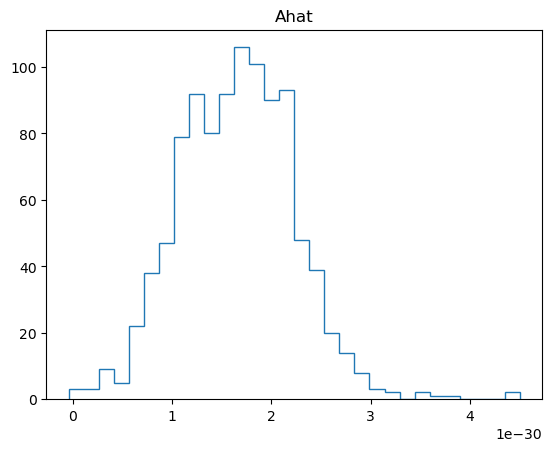

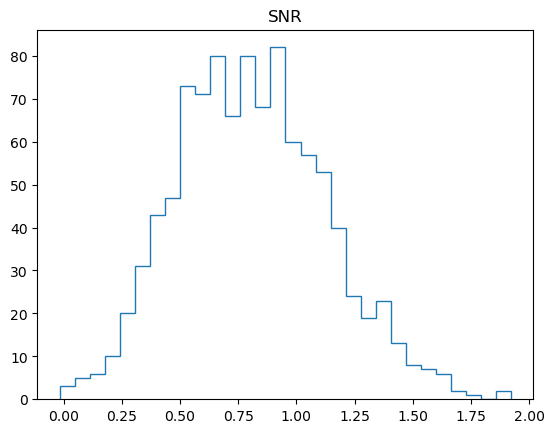

In [42]:
plt.hist(ahat,bins=30,histtype='step')
plt.title("Ahat")
plt.show()

plt.hist(snr,bins=30,histtype='step')
plt.title("SNR")
plt.show()

In [43]:
np.median(snr)

0.7938609867166475

In [44]:
np.save("/Users/kalistaw/Desktop/OS_2023_data/ppta_snr_vg_tspan_ppta_fx_gamma_dmgp_set.npy",snr)

In [ ]:
#NMOS in native PTA Space

In [24]:
with open ('/Users/kalistaw/Desktop/OS_2023_data/ppta_dmgp_max.pkl', 'rb') as fp:
    dm_gp_max_like = pickle.load(fp)

In [37]:
c0=co.Core(corepath="/Users/kalistaw/Desktop/OS_2023_data/ppta_dmgp_core_fx_gamma.h5")

Loading data from HDF5 file....


In [38]:
ppta_array=c0.chain
ppta_param_names=c0.params

In [39]:
ppta_param_namescp=[]
for ky in ppta_param_names:
    if "earth" not in ky:
        split=ky.split('_')
        split.insert(1,'ppta')
        kynew='_'.join(split)
        ppta_param_namescp.append(kynew)
    else:
        ppta_param_namescp.append(ky)

In [40]:
for i in range(len(ppta_param_namescp)):
    if ppta_param_namescp[i]=='gw_ppta_crn_gamma':
        ppta_param_namescp[i]='gw_gamma'
    elif ppta_param_namescp[i]=='gw_ppta_crn_log10_A':
        ppta_param_namescp[i]='gw_log10_A'
    else:
        pass

In [29]:
i=0
while i<len(ppta_array):
    dictionary_of_values = dict(zip(ppta_param_namescp, ppta_array[i]))
    dictionary_of_valcp=dictionary_of_values.copy()
    for key, value in dm_gp_max_like.items():
        for ky,val in dictionary_of_values.items():
            if ky == key:
                dictionary_of_valcp[ky]=value
            else:
                pass
    list_ppta_array=[]
    for ky,val in dictionary_of_valcp.items():
        list_ppta_array.append(val)
    ppta_array[i]=list_ppta_array
    
    i+=1

In [30]:
chain=ppta_array

In [33]:
ostat = opt_stat.OptimalStatistic(psrs, pta=pta, orf='hd')
ostat_dip = opt_stat.OptimalStatistic(psrs, pta=pta, orf='dipole')
ostat_mono = opt_stat.OptimalStatistic(psrs, pta=pta, orf='monopole')

In [34]:
%%time
# (Note: It may take a few minutes to run this cell)
N = 1000   # number of times to compute the optimal statistic - official analysis used 10k - you can increase this if you don't mind the extra runtime
burn = int(0.25*chain.shape[0])   # estimate of when the chain has burned in

noisemarg_OS, noisemarg_OS_err = np.zeros(N), np.zeros(N)
noisemarg_OS_dip, noisemarg_OS_dip_err = np.zeros(N), np.zeros(N)
noisemarg_OS_mono, noisemarg_OS_mono_err = np.zeros(N), np.zeros(N)

for i in range(N):
    if i%100==0:
        print("Status: ", i, "/", N, " -- ", i/N*100, " %")
    # choose a set of noise values from the chain
    # make sure that you pull values from after the chain has burned in
    idx = np.random.randint(burn, chain.shape[0])
    
    # construct a dictionary with these parameter values
    param_dict = {}
    for p in ppta_param_namescp:
        param_dict.update({p: chain[idx, ppta_param_namescp.index(p)]})
    
    # compute the optimal statistic at this set of noise values and save in an array
    _, _, _, noisemarg_OS[i], noisemarg_OS_err[i] = ostat.compute_os(params=param_dict)

Status:  0 / 1000  --  0.0  %
Status:  100 / 1000  --  10.0  %
Status:  200 / 1000  --  20.0  %
Status:  300 / 1000  --  30.0  %
Status:  400 / 1000  --  40.0  %
Status:  500 / 1000  --  50.0  %
Status:  600 / 1000  --  60.0  %
Status:  700 / 1000  --  70.0  %
Status:  800 / 1000  --  80.0  %
Status:  900 / 1000  --  90.0  %
CPU times: user 58.3 s, sys: 1.97 s, total: 1min
Wall time: 41.6 s


In [35]:
snr=noisemarg_OS/noisemarg_OS_err

In [36]:
np.median(snr)

-0.10445410569978207

In [59]:
np.save("/Users/kalistaw/Desktop/OS_2023_data/ppta_pta_space_mar_snr_fx_gamma_dmgp_set.npy",snr)